In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData

In [2]:
import copy

In [3]:
import time

In [4]:
class uvdata_pol_calibrator():
    
    def __init__(self, model_data=None, real_data=None):
        """
        Parameters
        ----------
        model_data, real_data : UVData
        """
        self.model_data, self.real_data = model_data, real_data
        self.gain_array = np.zeros((self.real_data.Nants_data, self.real_data.Nfreqs, 2, 2)).astype(np.complex128)
        self.gain_H_array = np.zeros((self.real_data.Nants_data,self.real_data.Nfreqs, 2, 2)).astype(np.complex128)
        
    def data_slice(self, use_all_times=False, md_time_range=[], rd_time_range=[], use_all_frequencies=False, md_freq_range=[], rd_freq_range=[], 
                   use_all_ants=False, md_ants=[], rd_ants=[]):
        """
        Get a slice of the data.
        
        Parameters
        ----------

       


        """
        if use_all_ants:
            ants = np.unique(self.real_data.ant_1_array)
        else:
            assert isinstance(md_ants, list) and isinstance(rd_ants, list), "ants must be a list." 
            md_ants, rd_ants= list(np.sort(md_ants)), list(np.sort(rd_ants))
            assert md_ants == rd_ants
            ants = rd_ants
        self.ants2cal = ants
        
        if use_all_times:
            md_time_range = [np.unique(self.model_data.time_array)[0]-1e-2, np.unique(self.model_data.time_array)[-1]+1e-2]
            rd_time_range = [np.unique(self.real_data.time_array)[0]-1e-2, np.unique(self.real_data.time_array)[-1]+1e-2]
        else:
            assert isinstance(md_time_range, list) and isinstance(rd_time_range, list), "time_range must be a list"
            assert len(md_time_range) == len(rd_time_range), "Length of time_ranges must be the same."
            assert len(md_time_range) == 2, "Length of time_range must be 2."
        
        if use_all_frequencies:
            md_freqs = list(range(self.model_data.Nfreqs))
            rd_freqs = list(range(self.real_data.Nfreqs))
        else:
            assert isinstance(md_freq_range, list) and isinstance(rd_freq_range, list), "freq_range must be a list"
            assert md_freq_range == rd_freq_range, "freq_ranges must be the same."
            if len(md_freq_range) == 1:
                md_freqs = md_freq_range
                rd_freqs = rd_freq_range
            elif len(md_freq_range) == 2:
                md_freqs = list(range(md_freq_range[0],md_freq_range[1]+1))
                rd_freqs = list(range(rd_freq_range[0],rd_freq_range[1]+1))
            else:
                raise ValueError("Length of freq_range must be 1 or 2.")
        self.freqs2cal = rd_freqs
        
        model_data_slice = self.model_data.select(antenna_nums=ants, freq_chans=md_freqs, time_range=md_time_range, inplace=False) 
        real_data_slice = self.real_data.select(antenna_nums=ants, freq_chans=rd_freqs, time_range=rd_time_range, inplace=False)             
        
        # original data_array shape: (Nblts, Nspws, Nfreqs, )
        # intermidiate data_array shape: (Nants, Nants, Nspws, Ntimes, Nfreqs, Npols)
        # final data_array shape: (Nants, Nants, :, 2, 2)
        assert model_data_slice.data_array.shape == real_data_slice.data_array.shape
        model_data_array = np.zeros((len(ants), len(ants), model_data_slice.Nspws, model_data_slice.Ntimes, model_data_slice.Nfreqs, model_data_slice.Npols)).astype(np.complex128)
        real_data_array = np.zeros((len(ants), len(ants), real_data_slice.Nspws, real_data_slice.Ntimes, real_data_slice.Nfreqs, real_data_slice.Npols)).astype(np.complex128)
        
        for (i, ant1) in enumerate(ants):
            for (j,ant2) in enumerate(ants):
                for spw in range(model_data_slice.Nspws): 
                    if ant1 <= ant2:
                        baseline_number = 2048*(ant1+1)+(ant2+1)+2**16
                        # baseline index = 2048 * (ant1+1) + (ant2+1) + 2**16
                        model_data_array[i,j,spw] = model_data_slice.get_data(baseline_number)
                        model_data_array_copy = model_data_slice.get_data(baseline_number)
                        # uvdata.get_data() returns an array with a shape (Ntimes, Nfreqs, Npols) 
                        model_data_array[i,j,spw, :,:,1],  model_data_array[i,j,spw, :,:,2],  model_data_array[i,j,spw, :,:,3] = model_data_array_copy[:,:,2],  model_data_array_copy[:,:,3],  model_data_array_copy[:,:,1]
                        """
                        data_array orginally stores the polarization information as a 1d array [-5, -6, -7, -8], corresponding to [XX, YY, XY, YX].
                        Here we first modify it into [-5,-7, -8,-6], 
                        then we will modify it into a 2d array[[-5,-7],[-8,-6]], corresponding to [[XX, XY], [YX, YY]].
                        """
                        real_data_array[i,j,spw] = real_data_slice.get_data(baseline_number)
                        real_data_array_copy = real_data_slice.get_data(baseline_number)
                        real_data_array[i,j,spw, :,:,1],  real_data_array[i,j,spw, :,:,2],  real_data_array[i,j,spw, :,:,3] = real_data_array_copy[:,:,2], real_data_array_copy[:,:,3], real_data_array_copy[:,:,1]

                    if ant1 > ant2:
                        baseline_number = 2048*(ant2+1)+(ant1+1)+2**16
                        model_data_array[i,j,spw] = np.conj(model_data_slice.get_data(baseline_number))
                        model_data_array_copy = np.conj(model_data_slice.get_data(baseline_number))
                        model_data_array[i,j,spw, :,:,1],  model_data_array[i,j,spw, :,:,2],  model_data_array[i,j,spw, :,:,3] = model_data_array_copy[:,:,3], model_data_array_copy[:,:,2], model_data_array_copy[:,:,1]
                        """
                        Since V_{ji} = V_{ij}^H, we should take conjugate values here and then reorder the pols as
                        [-5,-8, -7,-6], which becomes [[-5,-8],[-7,-6]] after converted into a 2d array.
                        """
                        real_data_array[i,j,spw] = np.conj(real_data_slice.get_data(baseline_number))
                        real_data_array_copy = np.conj(real_data_slice.get_data(baseline_number))
                        real_data_array[i,j,spw, :,:,1], real_data_array[i,j,spw, :,:,2], real_data_array[i,j,spw, :,:,3] = real_data_array_copy[:,:,3], real_data_array_copy[:,:,2], real_data_array_copy[:,:,1]


        data_shape = model_data_array.shape
        model_data_array = model_data_array.reshape((data_shape[0], data_shape[1], data_shape[2], data_shape[3], data_shape[4], 2, 2))
        real_data_array = real_data_array.reshape((data_shape[0], data_shape[1], data_shape[2], data_shape[3], data_shape[4], 2, 2))
        # reshape the pols
        model_data_array = model_data_array.reshape((data_shape[0], data_shape[1], data_shape[2]*data_shape[3]*data_shape[4], 2, 2))
        real_data_array = real_data_array.reshape((data_shape[0], data_shape[1], data_shape[2]*data_shape[3]*data_shape[4], 2, 2))
        # concatenate axis to a shape (Nants, Nants, :, 2, 2)

        self.model_data_array,  self.real_data_array = model_data_array, real_data_array
        
    def Wirtinger_lm_cal(self, diagonalize=False, Niteration=50, including_autobaseline=False, verbose=False):
        """
        Using Newton-Gauss method to obtain calibration gains G which minimizing \sum{D_[ij]-G_i M_{ij} G_j^H}, where D, G and M are all 2*2 matrices. 
        Update each step: G_{k+1} = [J(G_k)^H J(G_k)]^{-1} * J(G_k)^H * D, where J is the Jacobian matrix. 

        Parameters
        ----------

       

        Returns
        -------

        gain : dict
            calibration gains

        residual : 

        """
        ants, data, model = self.ants2cal, self.real_data_array, self.model_data_array
        gain_prev = np.array([[1,0],[0,1]]).astype(np.complex128)
        gain_prev = np.repeat(gain_prev[np.newaxis,:,:], len(ants), axis=0)
        gain_H_prev = np.copy(gain_prev)
        gain_next, gain_H_next = np.zeros_like(gain_prev), np.zeros_like(gain_prev)
        
        residual = np.zeros(Niteration)

        for iteration in range(Niteration):
            for (i,ant) in enumerate(ants):
                JH_J = np.zeros((2,2)).astype(np.complex128)
                JH_D = np.zeros((2,2)).astype(np.complex128)
                for (j,ant_q) in enumerate(ants):
                    # sum over baselines, frequencies and times
                    JH_J += np.sum(np.matmul(model[i,j], np.matmul(gain_H_prev[j], np.matmul(gain_prev[j], model[j,i]))), axis=0)
                    JH_D += np.sum(np.matmul(data[i,j], np.matmul(gain_prev[j], model[(j, i)])), axis=0)
                    
                if not including_autobaseline:
                    # if not including auto-baseline
                    JH_J -= np.sum(np.matmul(model[i,i], np.matmul(gain_H_prev[i], np.matmul(gain_prev[i], model[i,i]))), axis=0)
                    JH_D -= np.sum(np.matmul(data[i,i], np.matmul(gain_prev[i], model[(i, i)])), axis=0)         
                    """
                    if including_autobaseline:
                        # sum over baselines, frequencies and times
                        JH_J += np.sum(np.sum(np.matmul(model[(ant,ant_q)], np.matmul(gain_H_prev[ant_q], np.matmul(gain_prev[ant_q], model[(ant_q,ant)]))), axis=0), axis=0)
                        JH_D += np.sum(np.sum(np.matmul(data[(ant,ant_q)], np.matmul(gain_prev[ant_q], model[(ant_q, ant)])), axis=0), axis=0)
                    else:
                        if ant_q != ant:
                        # if not including auto-baseline
                            JH_J += np.sum(np.sum(np.matmul(model[(ant,ant_q)], np.matmul(gain_H_prev[ant_q], np.matmul(gain_prev[ant_q], model[(ant_q,ant)]))), axis=0), axis=0)
                            JH_D += np.sum(np.sum(np.matmul(data[(ant,ant_q)], np.matmul(gain_prev[ant_q], model[(ant_q, ant)])), axis=0), axis=0)
                    """
               
                if diagonalize==True:
                    gain_next[i] = np.diag(np.diag(np.matmul(JH_D, np.linalg.inv(JH_J))))
                else:
                    gain_next[i] = np.matmul(JH_D, np.linalg.inv(JH_J))
                JH_J = np.zeros((2,2)).astype(np.complex128)
                JH_D = np.zeros((2,2)).astype(np.complex128)
                for (k,ant_p) in enumerate(ants):
                    JH_J += np.sum(np.matmul(model[i,k], np.matmul(gain_H_prev[k], np.matmul(gain_prev[k], model[k,i]))), axis=0)
                    JH_D += np.sum(np.matmul(model[i,k], np.matmul(gain_H_prev[k], data[k, i])), axis=0)
                
                if not including_autobaseline:
                    JH_J -= np.sum(np.matmul(model[i,i], np.matmul(gain_H_prev[i], np.matmul(gain_prev[i], model[i,i]))), axis=0)
                    JH_D -= np.sum(np.matmul(model[i,i], np.matmul(gain_H_prev[i], data[i, i])), axis=0)
                    """
                    if including_autobaseline:
                        # sum over baselines, frequencies and times
                        JH_J += np.sum(np.sum(np.matmul(model[(ant,ant_p)], np.matmul(gain_H_prev[ant_p], np.matmul(gain_prev[ant_p], model[(ant_p,ant)]))), axis=0), axis=0)
                        JH_D += np.sum(np.sum(np.matmul(model[(ant,ant_p)], np.matmul(gain_H_prev[ant_p], data[(ant_p, ant)])), axis=0), axis=0)
                    else:
                        if ant_p != ant:
                        # if not including auto-baseline
                            JH_J += np.sum(np.sum(np.matmul(model[(ant,ant_p)], np.matmul(gain_H_prev[ant_p], np.matmul(gain_prev[ant_p], model[(ant_p,ant)]))), axis=0), axis=0)
                            JH_D += np.sum(np.sum(np.matmul(model[(ant,ant_p)], np.matmul(gain_H_prev[ant_p], data[(ant_p, ant)])), axis=0), axis=0)
                    """
                   
                if diagonalize==True:
                    gain_H_next[i] = np.diag(np.diag(np.matmul(np.linalg.inv(JH_J), JH_D)))
                else:
                    gain_H_next[i] = np.matmul(np.linalg.inv(JH_J), JH_D)

            gain_prev = gain_next
            gain_H_prev = gain_H_next

            for ant in range(len(ants)):
                for ant_r in range(len(ants)):
                    if including_autobaseline:
                         residual[iteration] += np.linalg.norm(data[ant,ant_r] - np.matmul(gain_prev[ant], np.matmul(model[ant,ant_r], gain_H_prev[ant_r])))
                    else:
                        if ant_r != ant:
                            residual[iteration] += np.linalg.norm(data[ant,ant_r] - np.matmul(gain_prev[ant], np.matmul(model[ant,ant_r], gain_H_prev[ant_r])))
        
        # Add results to self.gain_array
        ants_all = np.unique(self.real_data.ant_1_array)
        for i, ant in enumerate(ants):
            ant_index = np.where(ants_all==ant)
            for freq_index in self.freqs2cal:
                self.gain_array[ant_index, freq_index,:,:] = gain_prev[i,:,:]
                self.gain_H_array[ant_index, freq_index,:,:] = gain_H_prev[i,:,:]

        if verbose:
            print(residual)                    


In [5]:
uvd_model, uvd_data = UVData(), UVData()

In [6]:
uvd_data.read("/lustre/aoc/projects/hera/H1C_IDR2/2458106/zen.2458106.22245.HH.uvh5")

In [7]:
uvd_data.data_array = uvd_data.data_array*1e6

In [8]:
uvd_model.read("/lustre/aoc/projects/hera/zmartino/hera_calib_model/IDR2/abscal_files/zen.2458106.21913.uvh5")

Telescope mock-HERA is not in known_telescopes.


In [9]:
np.unique(uvd_data.time_array)

array([2458106.22251081, 2458106.22263509, 2458106.22275937,
       2458106.22288364, 2458106.22300792, 2458106.22313219,
       2458106.22325647, 2458106.22338074, 2458106.22350502,
       2458106.2236293 , 2458106.22375357, 2458106.22387785,
       2458106.22400212, 2458106.2241264 , 2458106.22425067,
       2458106.22437495, 2458106.22449923, 2458106.2246235 ,
       2458106.22474778, 2458106.22487205, 2458106.22499633,
       2458106.2251206 , 2458106.22524488, 2458106.22536916,
       2458106.22549343, 2458106.22561771, 2458106.22574198,
       2458106.22586626, 2458106.22599053, 2458106.22611481,
       2458106.22623909, 2458106.22636336, 2458106.22648764,
       2458106.22661191, 2458106.22673619, 2458106.22686046,
       2458106.22698474, 2458106.22710901, 2458106.22723329,
       2458106.22735757, 2458106.22748184, 2458106.22760612,
       2458106.22773039, 2458106.22785467, 2458106.22797894,
       2458106.22810322, 2458106.2282275 , 2458106.22835177,
       2458106.22847605,

In [10]:
np.unique(uvd_model.time_array)

array([2458106.21913026, 2458106.21925454, 2458106.21937881,
       2458106.21950309, 2458106.21962736, 2458106.21975164,
       2458106.21987591, 2458106.22000019, 2458106.22012446,
       2458106.22024874, 2458106.22037301, 2458106.22049729,
       2458106.22062156, 2458106.22074584, 2458106.22087012,
       2458106.22099439, 2458106.22111867, 2458106.22124294,
       2458106.22136722, 2458106.22149149, 2458106.22161577,
       2458106.22174004, 2458106.22186432, 2458106.22198859,
       2458106.22211287, 2458106.22223714, 2458106.22236142,
       2458106.22248569, 2458106.22260997, 2458106.22273424,
       2458106.22285852, 2458106.22298279, 2458106.22310707,
       2458106.22323134, 2458106.22335562, 2458106.22347989,
       2458106.22360417, 2458106.22372845, 2458106.22385272,
       2458106.223977  , 2458106.22410127, 2458106.22422555,
       2458106.22434982, 2458106.2244741 , 2458106.22459837,
       2458106.22472265, 2458106.22484692, 2458106.2249712 ,
       2458106.22509547,

In [11]:
uv_polcal = uvdata_pol_calibrator(model_data=uvd_model, real_data=uvd_data)

In [12]:
(2458106.22984308 - 2458106.22251081)*24*60

10.558468848466873

In [13]:
(2458106.2264625-2458106.21913026)*24*60

10.558425933122635

In [14]:
start_time = time.time()
for chan in range(0,1024,20):
                         md_freq_range=[chan], rd_freq_range=[chan], use_all_ants=True)
    uv_polcal.Wirtinger_lm_cal(diagonalize=False, Niteration=50)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3101.3031508922577 seconds ---


In [15]:
np.save("gain_info",uv_polcal.gain_array)

## Visulization of the gains

Text(0.5, 1.0, 'yy - phase')

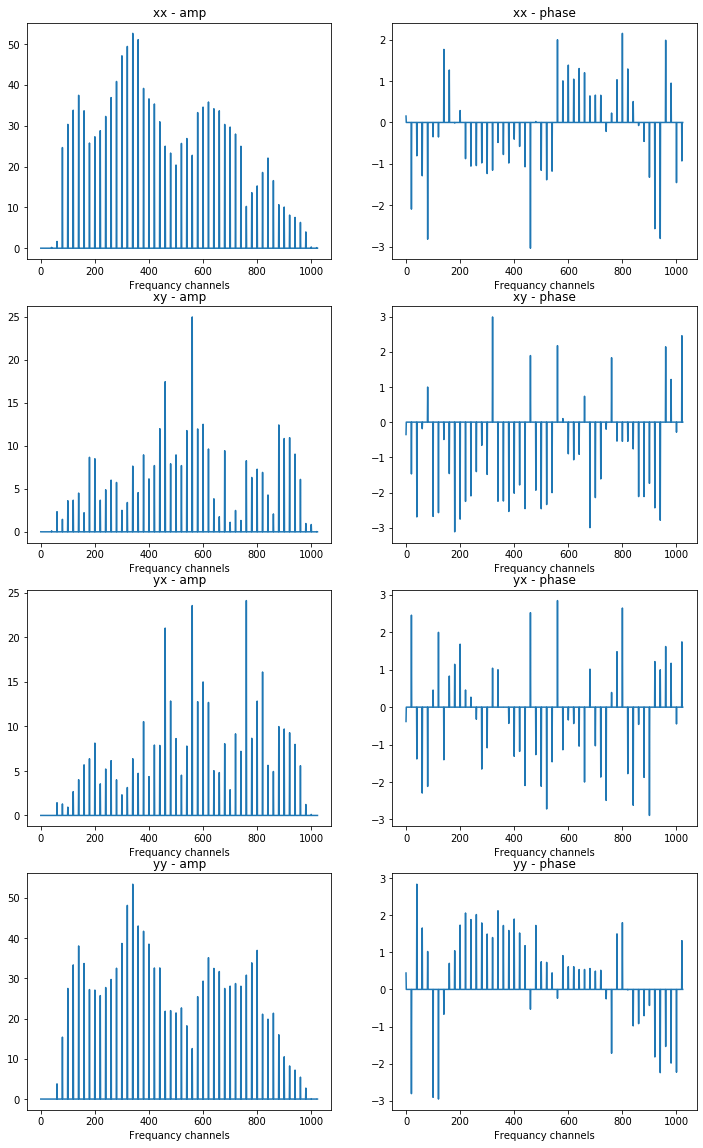

In [26]:
fig, axes = plt.subplots(figsize=(12,20), nrows=4, ncols=2)
ax = axes[0,0]
ax.plot(abs(uv_polcal.gain_array[12,:,0,0]))
ax.set_xlabel("Frequancy channels")
ax.set_title("xx - amp")
ax = axes[0,1]
ax.plot(np.angle(uv_polcal.gain_array[12,:,0,0]))
ax.set_xlabel("Frequancy channels")
ax.set_title("xx - phase")

ax = axes[1,0]
ax.plot(abs(uv_polcal.gain_array[12,:,0,1]))
ax.set_xlabel("Frequancy channels")
ax.set_title("xy - amp")
ax = axes[1,1]
ax.plot(np.angle(uv_polcal.gain_array[12,:,0,1]))
ax.set_xlabel("Frequancy channels")
ax.set_title("xy - phase")

ax = axes[2,0]
ax.plot(abs(uv_polcal.gain_array[12,:,1,0]))
ax.set_xlabel("Frequancy channels")
ax.set_title("yx - amp")
ax = axes[2,1]
ax.plot(np.angle(uv_polcal.gain_array[12,:,1,0]))
ax.set_xlabel("Frequancy channels")
ax.set_title("yx - phase")

ax = axes[3,0]
ax.plot(abs(uv_polcal.gain_array[12,:,1,1]))
ax.set_xlabel("Frequancy channels")
ax.set_title("yy - amp")
ax = axes[3,1]
ax.plot(np.angle(uv_polcal.gain_array[12,:,1,1]))
ax.set_xlabel("Frequancy channels")
ax.set_title("yy - phase")